# Using LLMs as High-Level Planners for Multi-Agent Coordination

This notebook provides a step-by-step guide to customizing and interacting with the RL environment.

## For Submission
1. Fill in your code in `submit.py`. 
   - Add your code *only* in the TODO sections marked by the '#' delimiter lines. Do not modify any other parts of the script.
   - You should implement any helper functions/classes in a separate `helper.py` file and import them in `submit.py`.
1. Submit `out.log` and `results.csv` generated by the `submit.py` script.


In [1]:
# Import necessary libraries and modules
import gymnasium as gym
import multigrid.envs
import matplotlib.pyplot as plt
from agents import AgentCollection

%matplotlib inline
%load_ext autoreload
%autoreload 2

c:\Users\cyihui\AppData\Local\miniforge3\envs\multigoal\lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


---
## Environment
- $N$ × $N$ square grid, where 50 ≤ $N$ ≤ 100.
  - The boundary cells are walls and hence the effective movement area will be ($N$ - 1) x ($N$ - 1).
- $M$ agents, where 2 ≤ $M$ ≤ 5, are placed at the same initial position at coordionate (1, 1).
- $T$ hidden targets are randomly placed in the grid.
- At the start of each episode, the environment provides a mission description, indicating regions (bounding box) where the targets are likely to be found.
  - e.g., “The region from (0, 0) to (5, 5) contains 5 targets. The region from (5, 5) to (10, 10) contains 5 targets.”

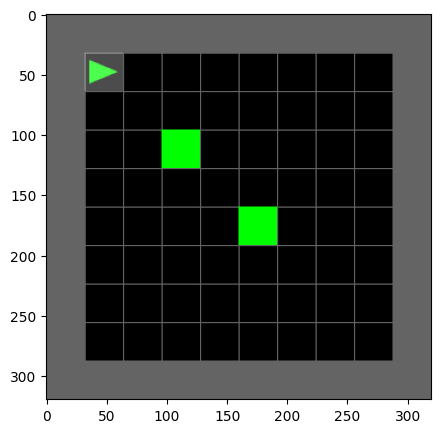

In [2]:
# # Use a predefined environment
# env = gym.make('MultiGrid-EmptyEnvV2-hidden-20x20-v0', agents=2, render_mode='rgb_array')

# Customize the environment
env = multigrid.envs.EmptyEnvV2(size=10, # Specify the size of the grid, N
                                agents=2, # Specify number of agents, M
                                goals=[(3, 3), (5, 5)], # Specify target positions for agents
                                mission_space= "All targets are contained within the region from (3, 3) to (5, 5).",
                                render_mode='rgb_array', 
                                hidden_goals=True, 
                                # max_steps=50, # For debugging, you can set a maximum number of steps
                                )

# Always reset the environment before starting
observations, infos = env.reset()

# Render the environment
img = env.render()
plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.show()

---
## Action Space

At each timestep *t*, the environment takes in a dictionary of low-level actions(LLA: left, right, up, down, nothing) for each agent and execute them.

However, for our purpose, we are interested in using LLM to control the agent behavior via the following high-level actions (HLA): 
- `move(cur_x, cur_y, tar_x, tar_y)`\
Instruct an agent to move from its current location (`cur_x`, `cur_y`) to the target coordinate (`tar_x`, `tar_y`).
- `search(cur_x, cur_y, x1, y1, x2, y2)`\
Instruct an agent at current location (`cur_x`, `cur_y`) to search within the rectangular region bounded by (`x1`, `y1`) and (`x2`, `y2`).
- `stop()`\
Instruct the agent to stop all activity and ignore current instructions.

Given a high-level action, an agent will automatically translated it into low-level action sequences. For example,
`move(1, 1, 3, 3)` → [`right`, `right`, `down`, `down`].

IMPT: The high-level actions follow strict formatting. e.g., ensure all the brackets and commas(if applicable) are present. 


### `move(cur_x, cur_y, tar_x, tar_y)`
Instruct an agent to move from its current location (`cur_x`, `cur_y`) to a target coordinate (`tar_x`, `tar_y`).

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.done: 7>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


c:\Users\Koki\miniforge3\envs\gridworld\lib\site-packages\gymnasium\utils\passive_env_checker.py:130: UserWarning: WARN: The obs returned by the `reset()` method was expecting a numpy array, actual type: <class 'tuple'>
  logger.warn(
c:\Users\Koki\miniforge3\envs\gridworld\lib\site-packages\gymnasium\spaces\box.py:423: UserWarning: WARN: Casting input x to numpy array.
  gym.logger.warn("Casting input x to numpy array.")
c:\Users\Koki\miniforge3\envs\gridworld\lib\site-packages\gymnasium\utils\passive_env_checker.py:227: UserWarning: WARN: Expects `terminated` signal to be a boolean, actual type: <class 'dict'>
  logger.warn(
c:\Users\Koki\miniforge3\envs\gridworld\lib\site-packages\gymnasium\utils\passive_env_checker.py:231: UserWarning: WARN: Expects `truncated` signal to be a boolean, actual type: <class 'dict'>
  logger.warn(
c:\Users\Koki\miniforge3\envs\gridworld\lib\site-packages\gymnasium\utils\passive_env_checker.py:130: UserWarning: WARN: The obs returned by the `step()` met

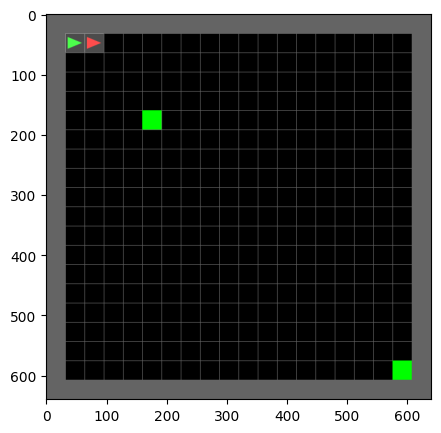

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.done: 7>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


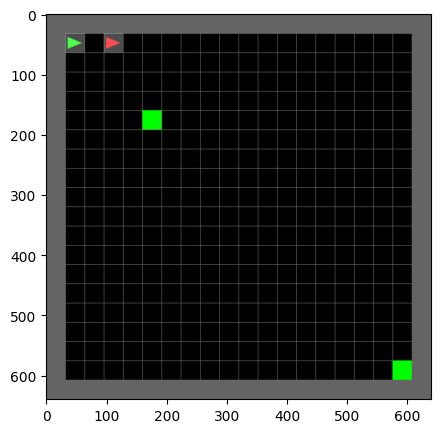

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.done: 7>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


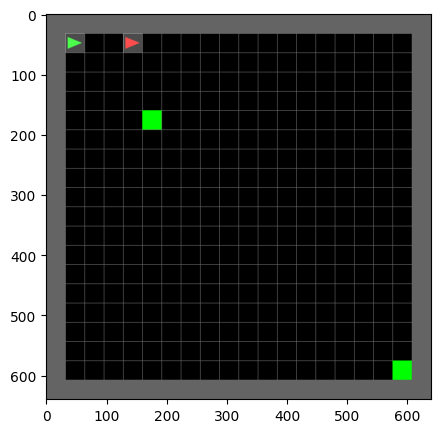

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.done: 7>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


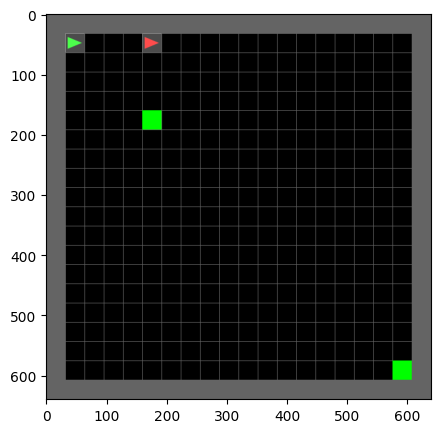

{0: <ActionUpDown.down: 3>, 1: <ActionUpDown.done: 7>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


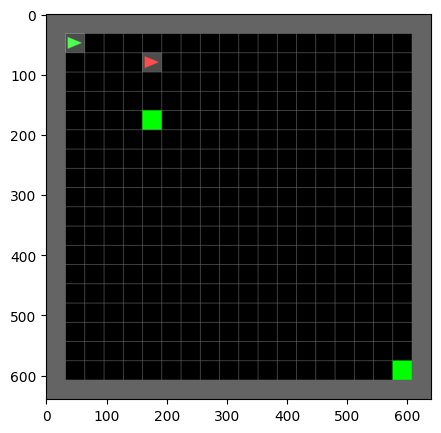

{0: <ActionUpDown.down: 3>, 1: <ActionUpDown.done: 7>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


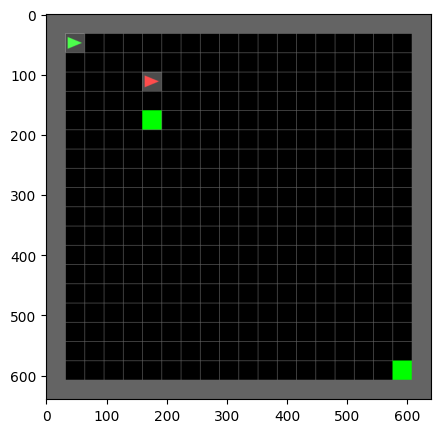

{0: <ActionUpDown.down: 3>, 1: <ActionUpDown.done: 7>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


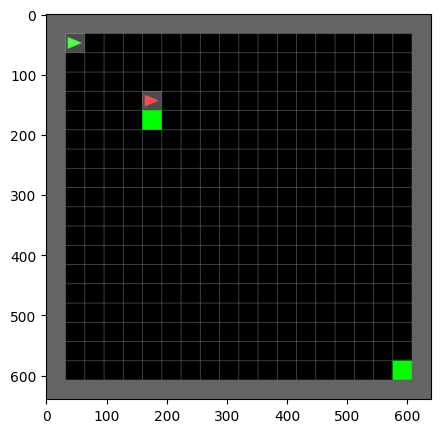

{0: <ActionUpDown.down: 3>, 1: <ActionUpDown.done: 7>} {0: 1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


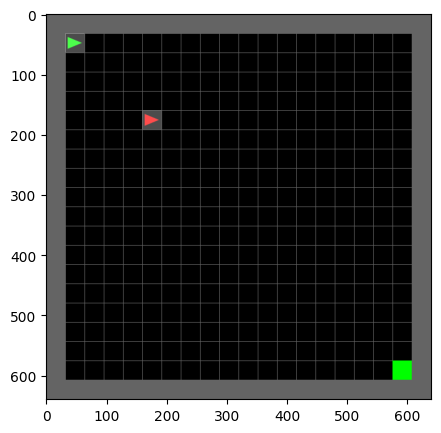

In [ ]:
env = gym.make('MultiGrid-EmptyEnvV2-hidden-20x20-v0', agents=2, render_mode='rgb_array')

# Always reset the environment before starting
observations, infos = env.reset()

# Create a group of 2 agents
agents = AgentCollection(num=2)

# Providing the agents with high-level instructions
# This will be the main function you will use to give instructions to the agents.
# These instructions should be generated by your LLM and not hardcoded. 
# The format is: {agent_id: "high_level_instruction"}
agents.tell({
    0: "move(1, 1, 5, 5)",
    # 1: "move(1, 1, 3, 3)", # Uncomment to give instruction to both agents
})

while not agents.all_idle() and not env.unwrapped.is_done():
    # Obtain the low-level action for current time step for all agents
    a = agents.act() 
    
    # Step the environment with the actions
    observations, rewards, terminations, truncations, infos = env.step(a)
    print(a, rewards, terminations, truncations)
    
    # Render the environment
    img = env.render()
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.show()
    
env.close()

### `search(cur_x, cur_y, x1, y1, x2, y2)`
Instruct an agent at current location (`cur_x`, `cur_y`) to search within the rectangular region bounded by (`x1`, `y1`)and (`x2`, `y2`).

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


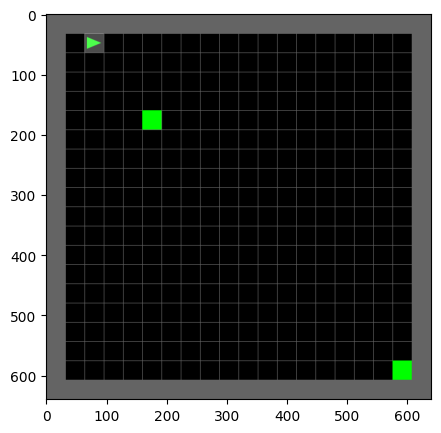

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


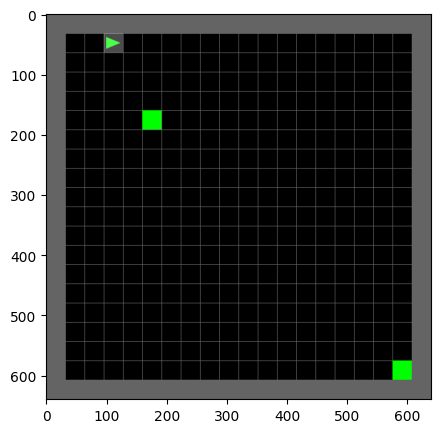

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


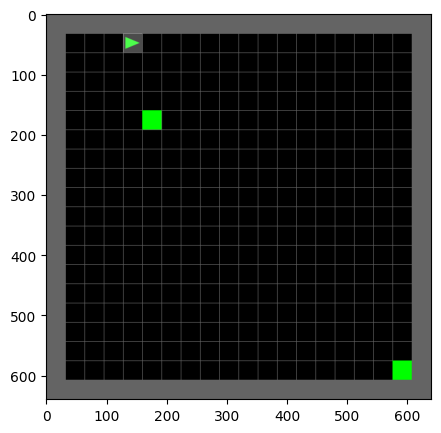

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


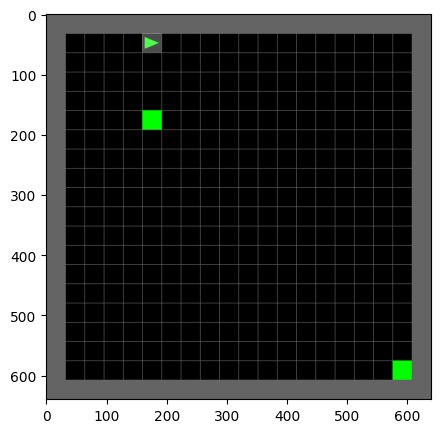

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


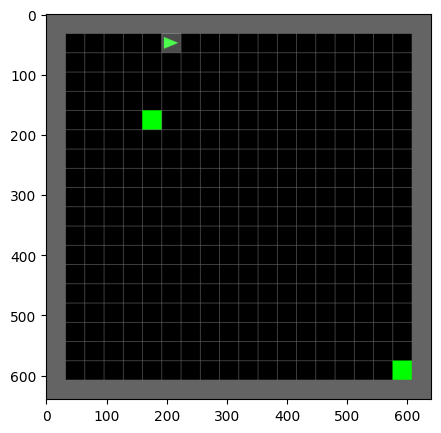

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


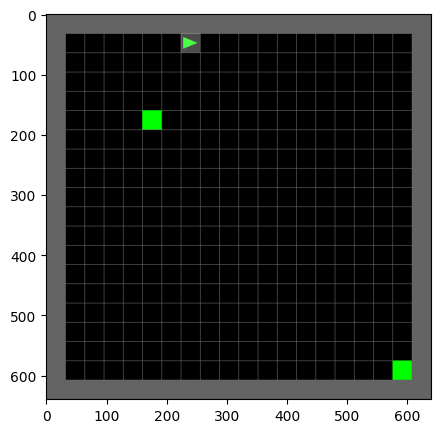

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


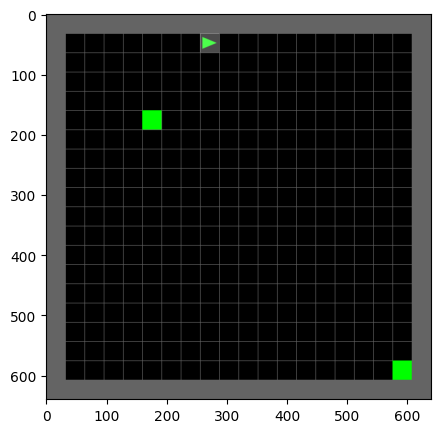

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


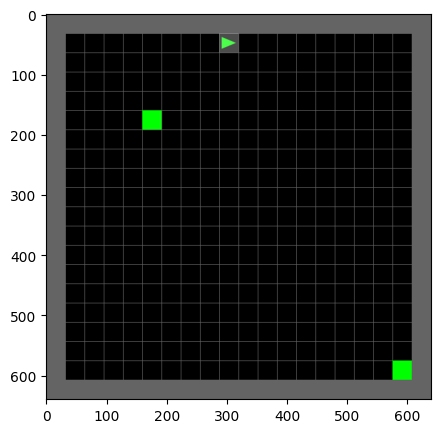

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


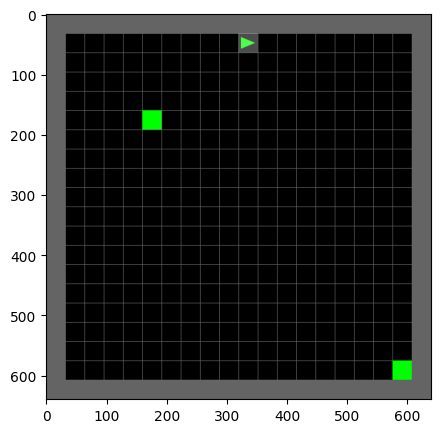

{0: <ActionUpDown.down: 3>, 1: <ActionUpDown.down: 3>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


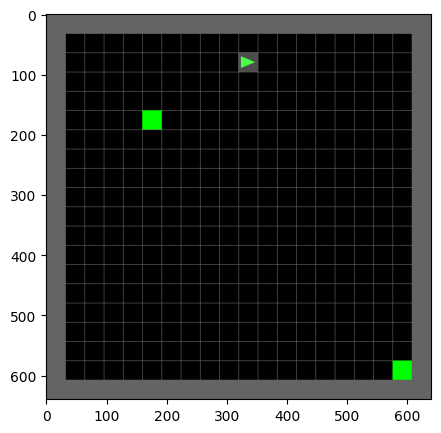

{0: <ActionUpDown.down: 3>, 1: <ActionUpDown.down: 3>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


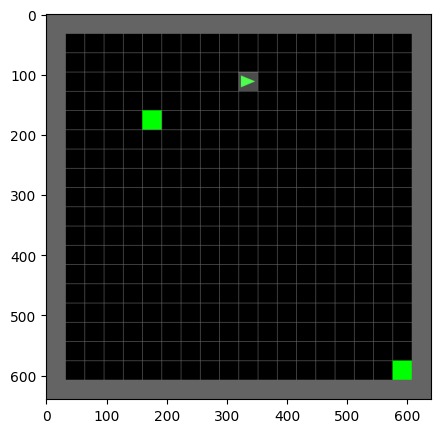

{0: <ActionUpDown.down: 3>, 1: <ActionUpDown.down: 3>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


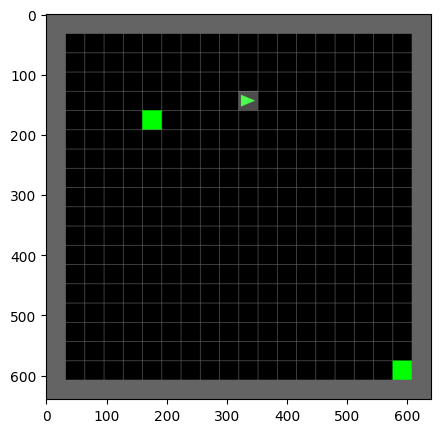

{0: <ActionUpDown.down: 3>, 1: <ActionUpDown.down: 3>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


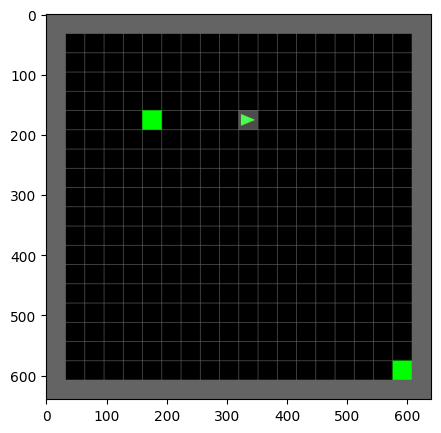

{0: <ActionUpDown.down: 3>, 1: <ActionUpDown.down: 3>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


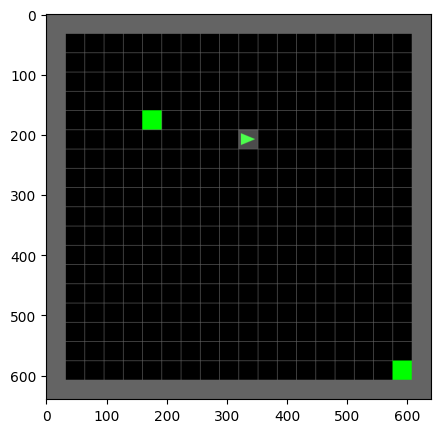

{0: <ActionUpDown.down: 3>, 1: <ActionUpDown.down: 3>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


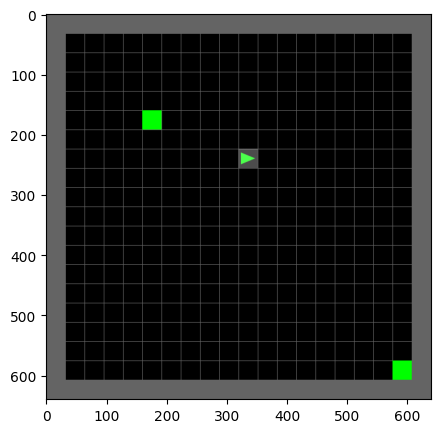

{0: <ActionUpDown.down: 3>, 1: <ActionUpDown.down: 3>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


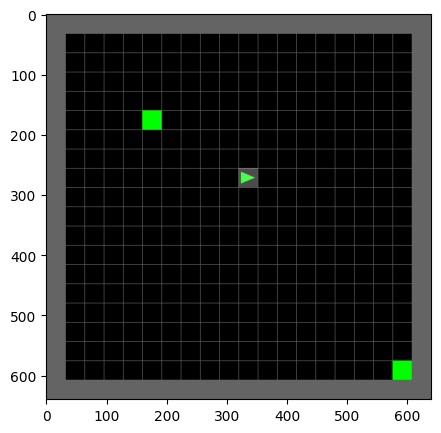

{0: <ActionUpDown.down: 3>, 1: <ActionUpDown.down: 3>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


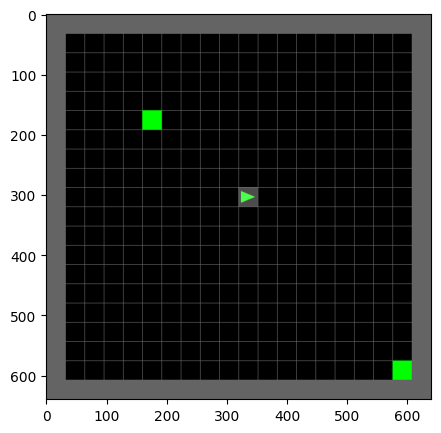

{0: <ActionUpDown.down: 3>, 1: <ActionUpDown.down: 3>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


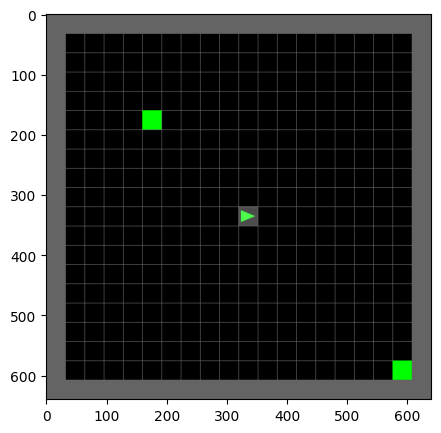

{0: <ActionUpDown.left: 0>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


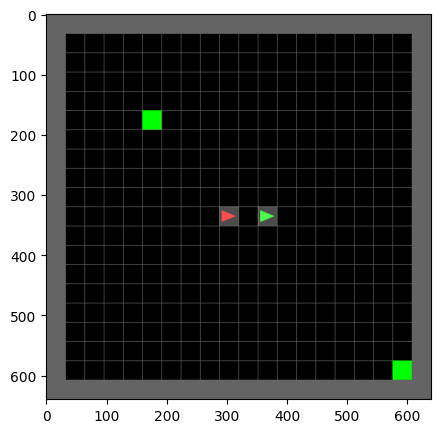

{0: <ActionUpDown.left: 0>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


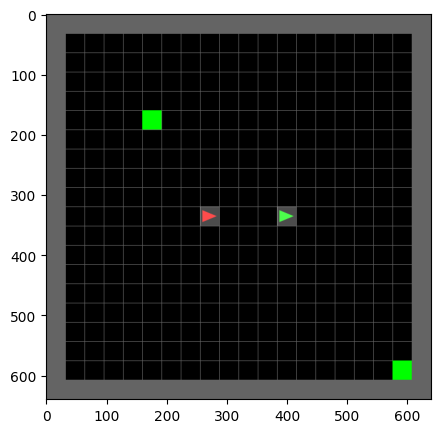

{0: <ActionUpDown.left: 0>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


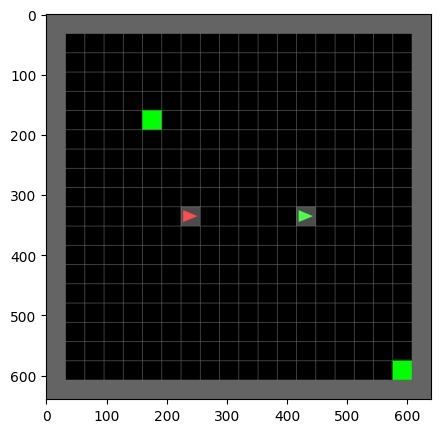

{0: <ActionUpDown.left: 0>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


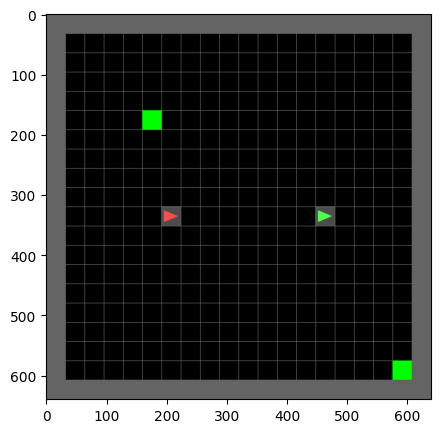

{0: <ActionUpDown.left: 0>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


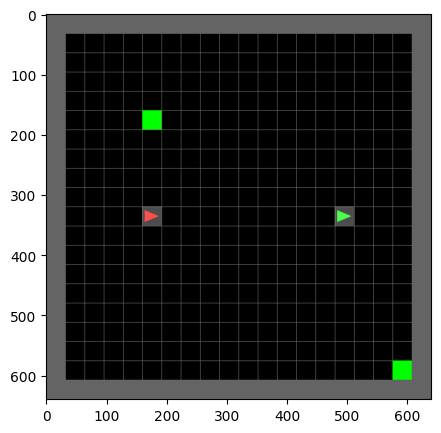

{0: <ActionUpDown.up: 2>, 1: <ActionUpDown.down: 3>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


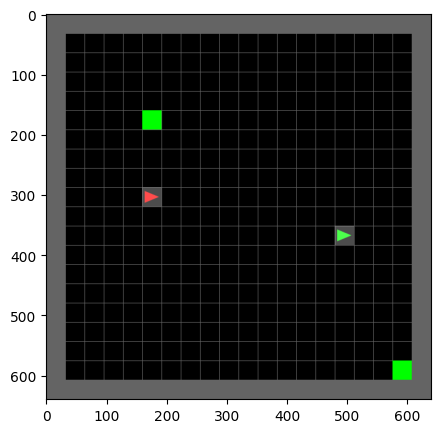

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.left: 0>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


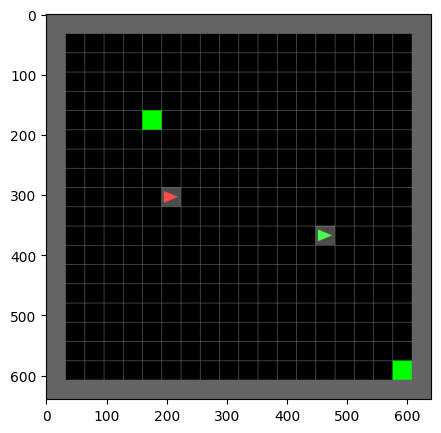

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.left: 0>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


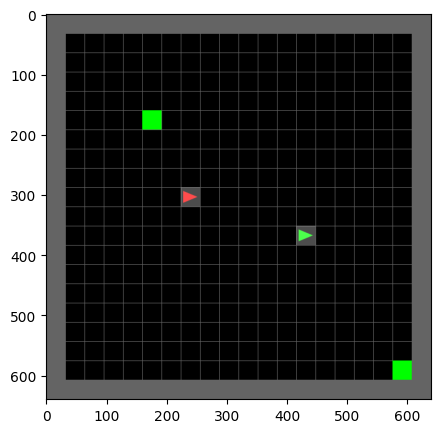

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.left: 0>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


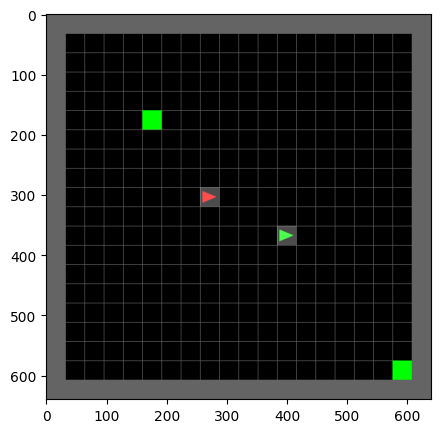

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.left: 0>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


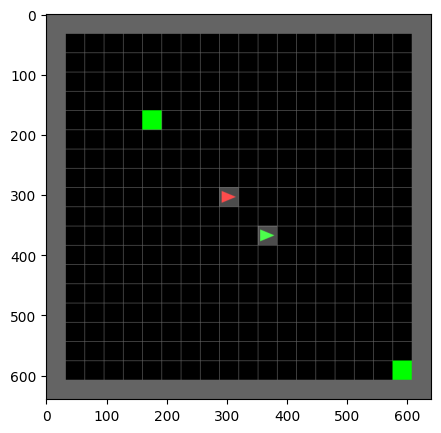

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.left: 0>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


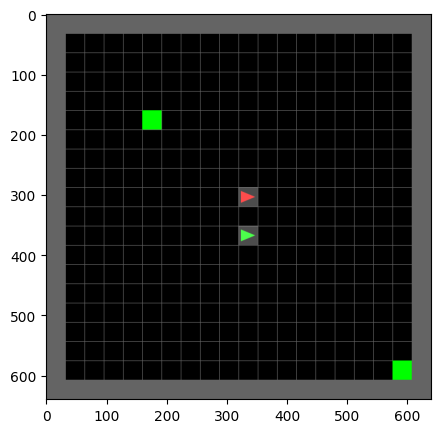

{0: <ActionUpDown.up: 2>, 1: <ActionUpDown.down: 3>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


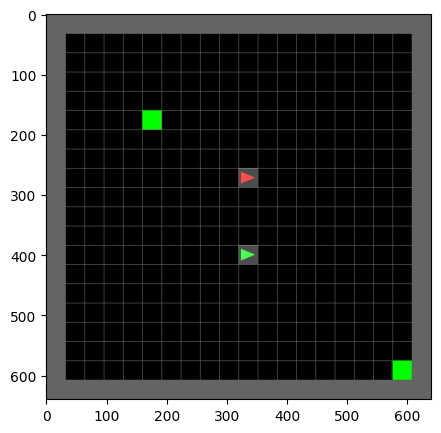

{0: <ActionUpDown.left: 0>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


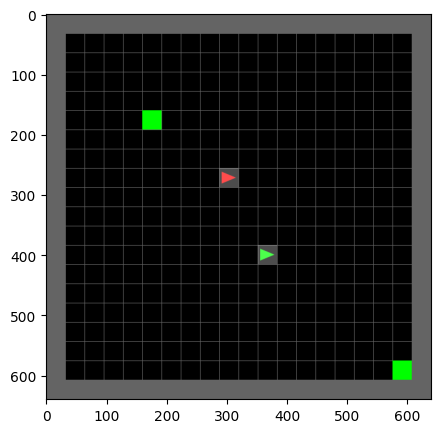

{0: <ActionUpDown.left: 0>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


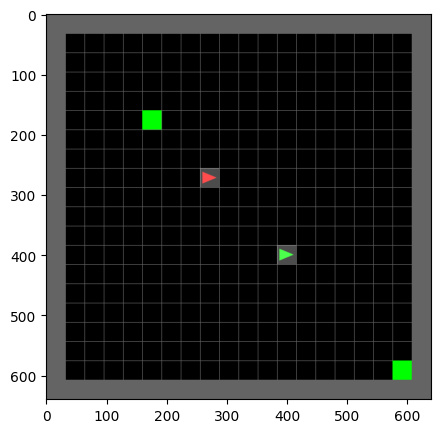

{0: <ActionUpDown.left: 0>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


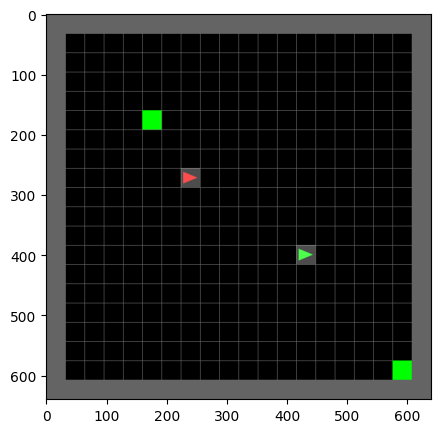

{0: <ActionUpDown.left: 0>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


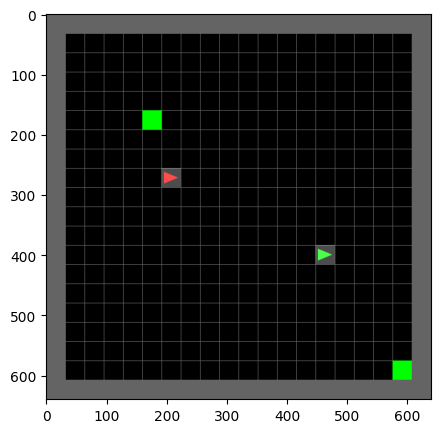

{0: <ActionUpDown.left: 0>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


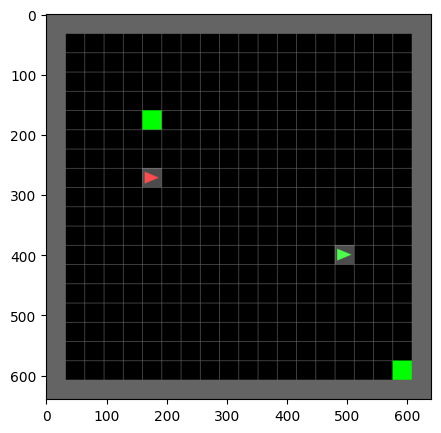

{0: <ActionUpDown.up: 2>, 1: <ActionUpDown.down: 3>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


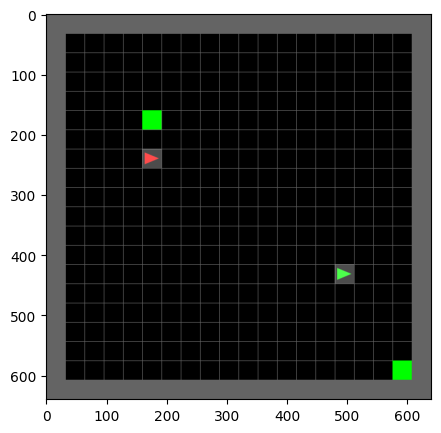

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.left: 0>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


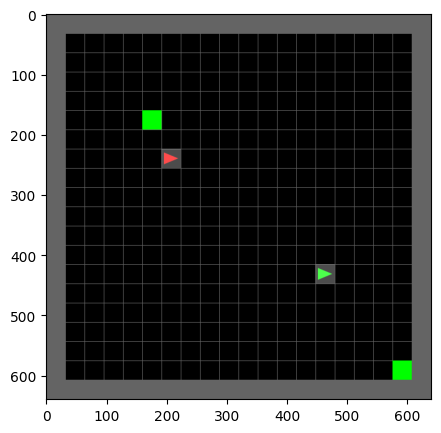

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.left: 0>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


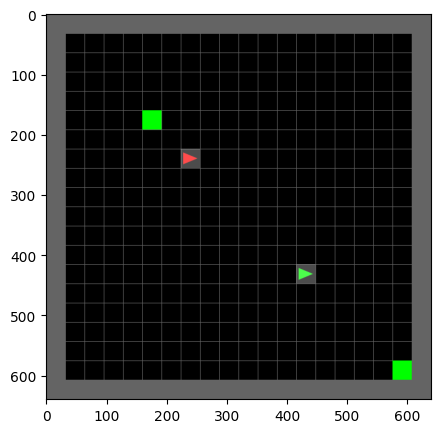

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.left: 0>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


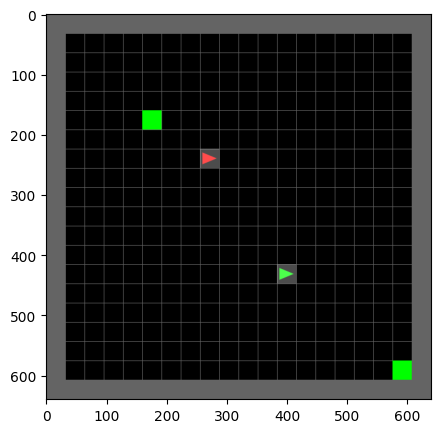

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.left: 0>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


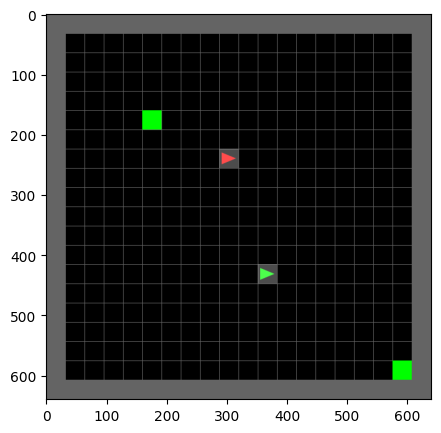

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.left: 0>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


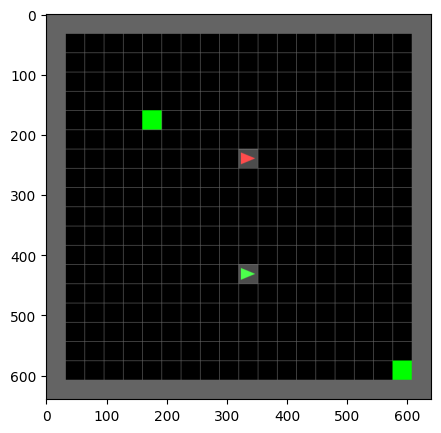

{0: <ActionUpDown.up: 2>, 1: <ActionUpDown.down: 3>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


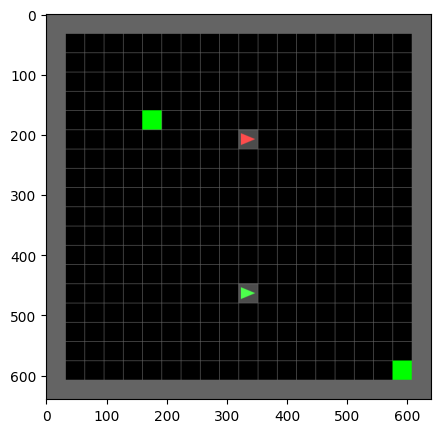

{0: <ActionUpDown.left: 0>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


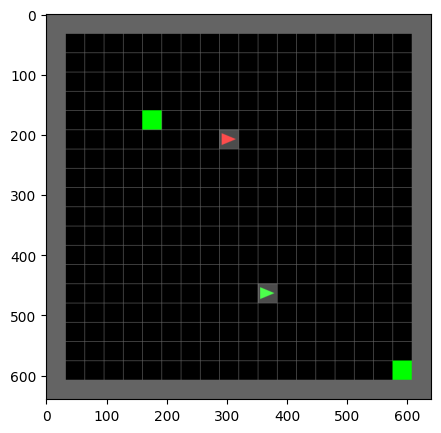

{0: <ActionUpDown.left: 0>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


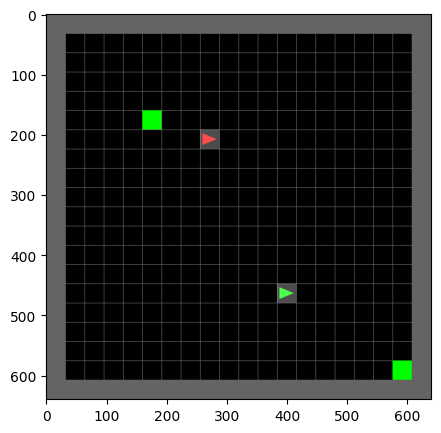

{0: <ActionUpDown.left: 0>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


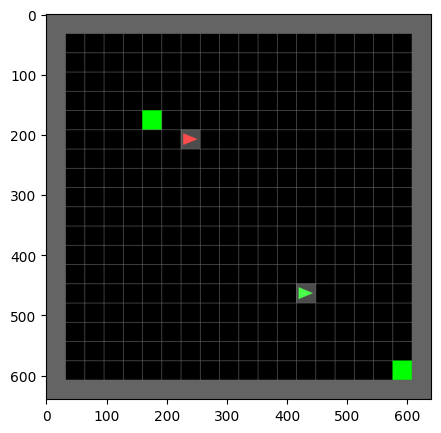

{0: <ActionUpDown.left: 0>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


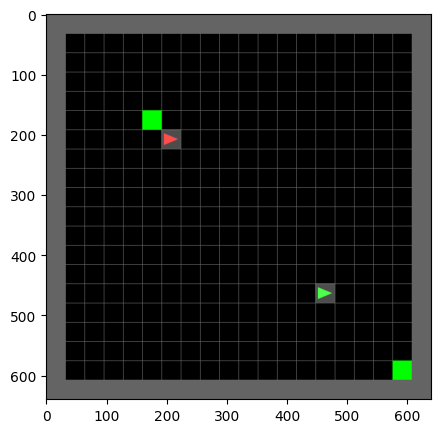

{0: <ActionUpDown.left: 0>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


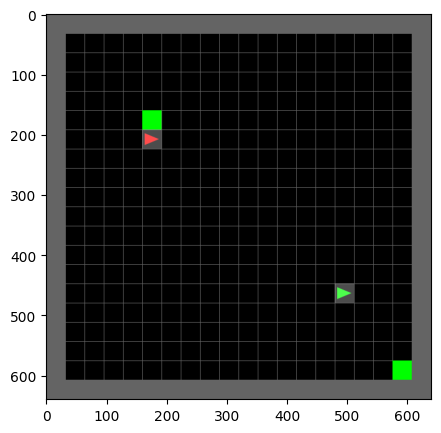

{0: <ActionUpDown.up: 2>, 1: <ActionUpDown.down: 3>} {0: 1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


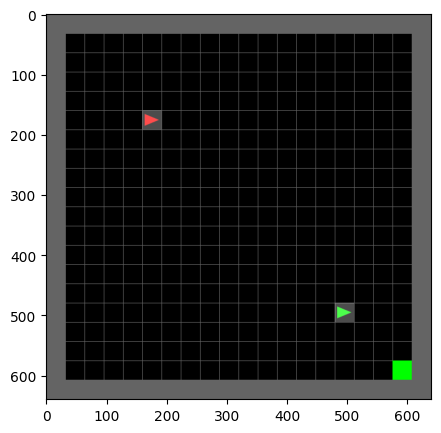

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.left: 0>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


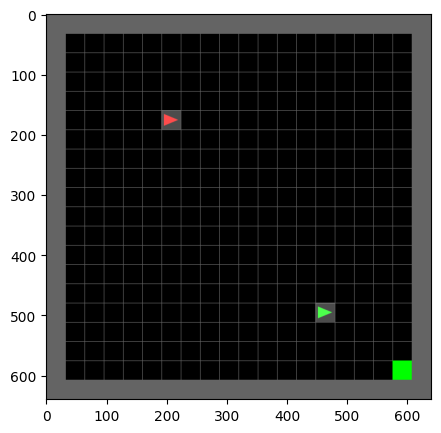

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.left: 0>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


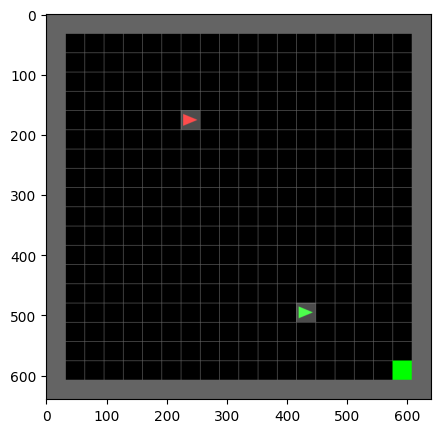

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.left: 0>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


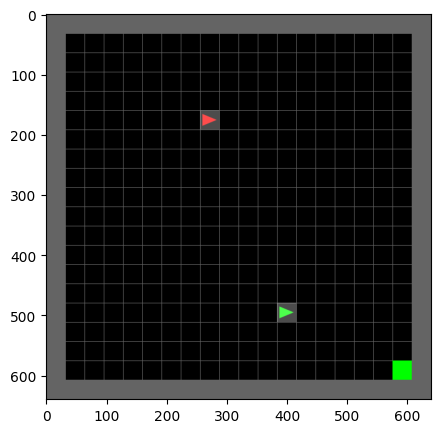

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.left: 0>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


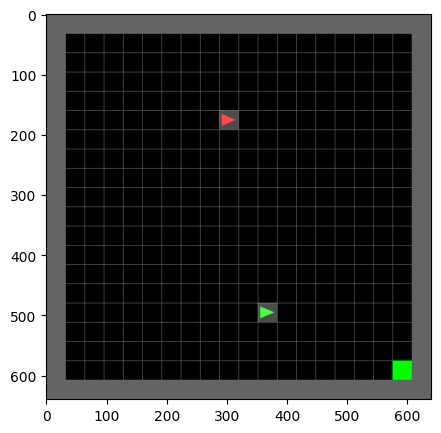

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.left: 0>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


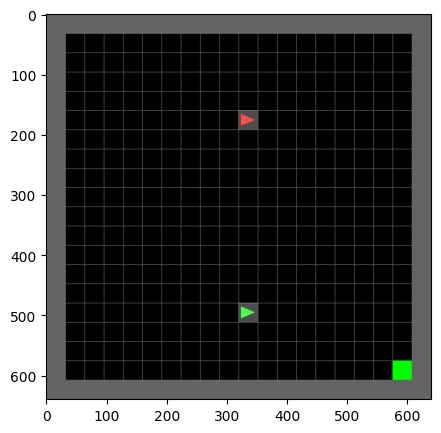

In [ ]:
env = gym.make('MultiGrid-EmptyEnvV2-hidden-20x20-v0', agents=2, render_mode='rgb_array')

# Always reset the environment before starting
observations, infos = env.reset()

# Create a group of 2 agents
agents = AgentCollection(num=2)

# Providing the agents with high-level instructions.
# Again, these instructions should be generated by your LLM and not hardcoded.
agents.tell({
    0: "search(1, 1, 10, 10, 5, 5)",
    1: "search(1, 1, 10, 10, 15, 15)"
})

while not agents.all_idle() and not env.unwrapped.is_done():
    # Obtain the low-level action for current time step for all agents
    a = agents.act()
    
    # Step the environment with the actions
    observations, rewards, terminations, truncations, infos = env.step(a)
    print(a, rewards, terminations, truncations)
    
    # Render the environment
    img = env.render()
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.show()
env.close()

### `stop()`
Instruct an agent to stop all activity and ignore current instructions. 
In the example below, we stopped Agent 0 after 5 steps while Agent 1 continues. This command can be useful for dynamic replanning. 

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


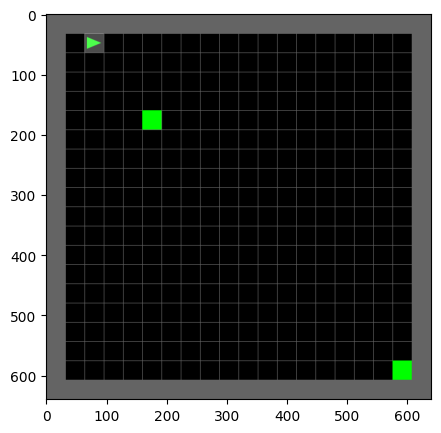

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


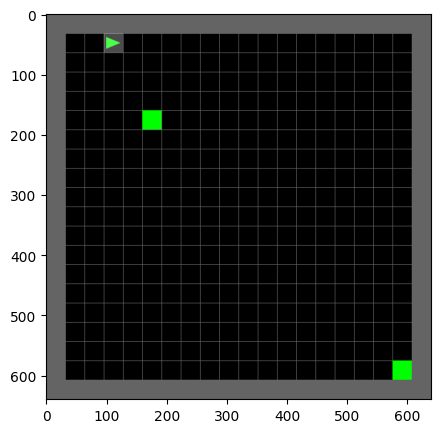

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


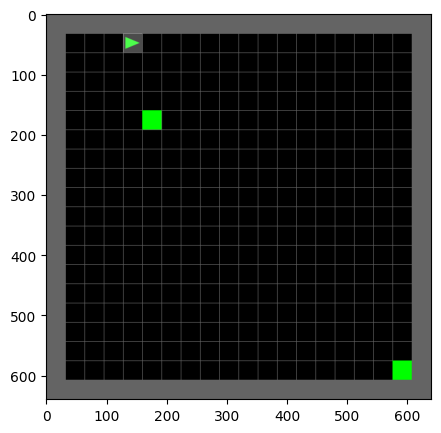

{0: <ActionUpDown.done: 7>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


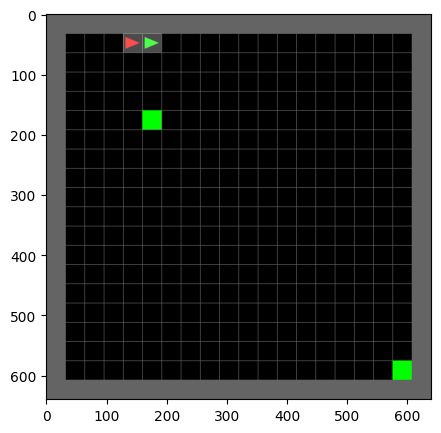

{0: <ActionUpDown.done: 7>, 1: <ActionUpDown.down: 3>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


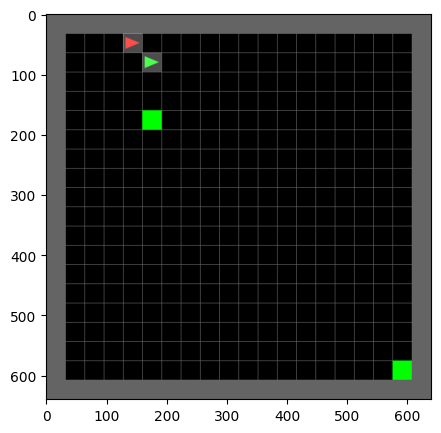

{0: <ActionUpDown.done: 7>, 1: <ActionUpDown.down: 3>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


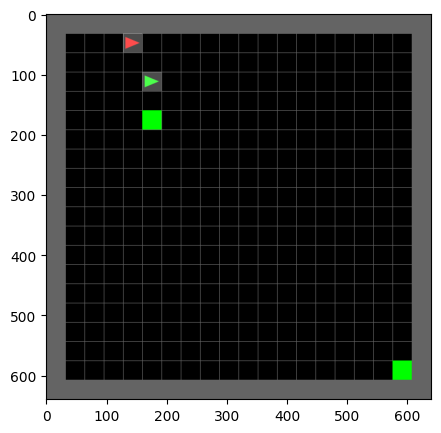

{0: <ActionUpDown.done: 7>, 1: <ActionUpDown.down: 3>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


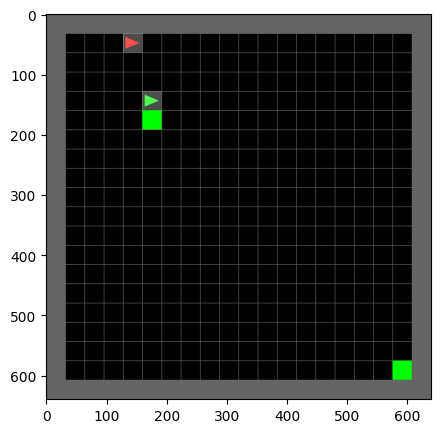

{0: <ActionUpDown.done: 7>, 1: <ActionUpDown.down: 3>} {0: -1, 1: 1} {0: np.False_, 1: np.False_} {0: False, 1: False}


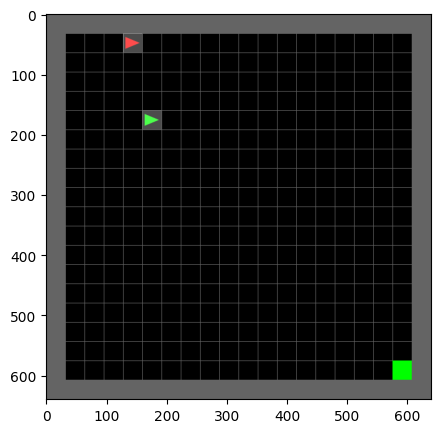

In [ ]:
env = gym.make('MultiGrid-EmptyEnvV2-hidden-20x20-v0', agents=2, render_mode='rgb_array')

# Always reset the environment before starting
observations, infos = env.reset()

# Create a group of 2 agents
agents = AgentCollection(num = 2)

# Providing the agents with high-level instructions.
# Again, these instructions should be generated by your LLM and not hardcoded.
agents.tell({
    0: "move(1, 1, 5, 5)",
    1: "move(1, 1, 5, 5)",
})

step = 0
while not agents.all_idle() and not env.unwrapped.is_done():
    # Obtain the low-level action for current time step for all agents
    a = agents.act()
    
    # Step the environment with the actions
    observations, rewards, terminations, truncations, infos = env.step(a)
    print(a, rewards, terminations, truncations)
    
    # Render the environment
    img = env.render()
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.show()
    step += 1
    if step == 3:  # Stop after 10 steps
        agents.tell({0: "stop()"})
env.close()

---
## Observations

At each timestep, the environment provides the following observations:
- Locations of agents
- The number of remaining targets
- Which agents are idling (i.e., completed all their high-level actions)
- Mission statement

IMPT: You are only allowed to use these information for your LLM planner.
The following example illustrates how to obtain these infomation from the env. 

Initial Observations:
dict_keys([0, 1, 'global'])
Mission: One target is contained within the region from (1, 1) to (5, 5).
Num of remaining target(s): 1
Agent 0's Location: (np.int64(1), np.int64(1))
Agent 1's Location: (np.int64(1), np.int64(1))


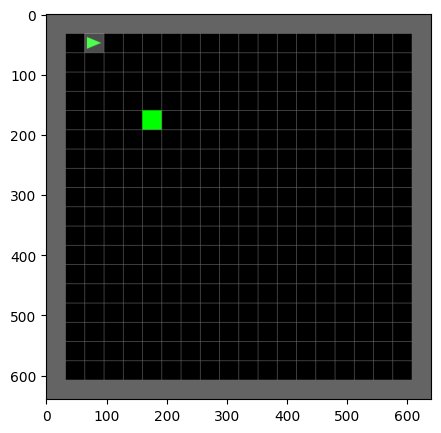

After Step 1: 
dict_keys([0, 1, 'global'])
Num of remaining target(s): 1
Agent 0's Location: (np.int64(2), np.int64(1))
Agent 1's Location: (np.int64(2), np.int64(1))
Are agents idling? False
Is Agent 0 idling? False
Is Agent 1 idling? False
Terminations: False {0: np.False_, 1: np.False_}
Truncations: {0: False, 1: False}


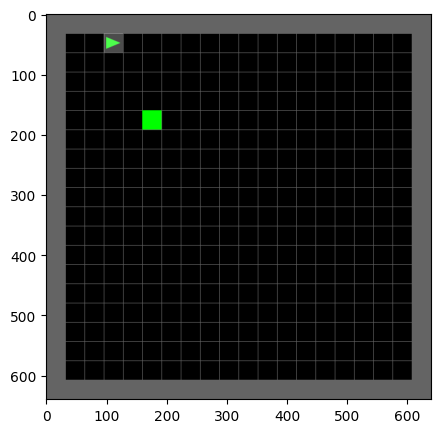

After Step 2: 
dict_keys([0, 1, 'global'])
Num of remaining target(s): 1
Agent 0's Location: (np.int64(3), np.int64(1))
Agent 1's Location: (np.int64(3), np.int64(1))
Are agents idling? False
Is Agent 0 idling? False
Is Agent 1 idling? False
Terminations: False {0: np.False_, 1: np.False_}
Truncations: {0: False, 1: False}


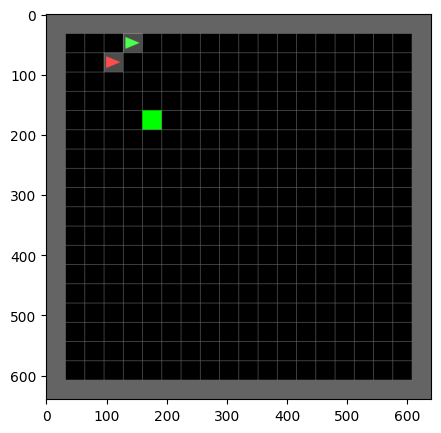

After Step 3: 
dict_keys([0, 1, 'global'])
Num of remaining target(s): 1
Agent 0's Location: (np.int64(3), np.int64(2))
Agent 1's Location: (np.int64(4), np.int64(1))
Are agents idling? False
Is Agent 0 idling? False
Is Agent 1 idling? False
Terminations: False {0: np.False_, 1: np.False_}
Truncations: {0: False, 1: False}


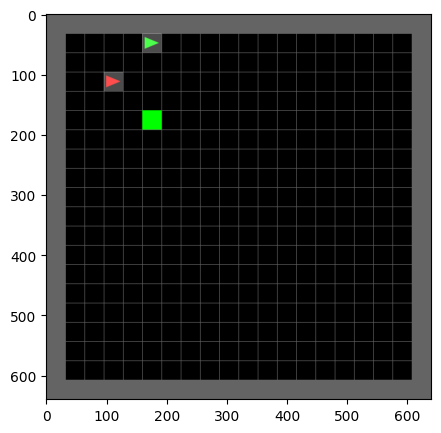

After Step 4: 
dict_keys([0, 1, 'global'])
Num of remaining target(s): 1
Agent 0's Location: (np.int64(3), np.int64(3))
Agent 1's Location: (np.int64(5), np.int64(1))
Are agents idling? False
Is Agent 0 idling? True
Is Agent 1 idling? False
Terminations: False {0: np.False_, 1: np.False_}
Truncations: {0: False, 1: False}


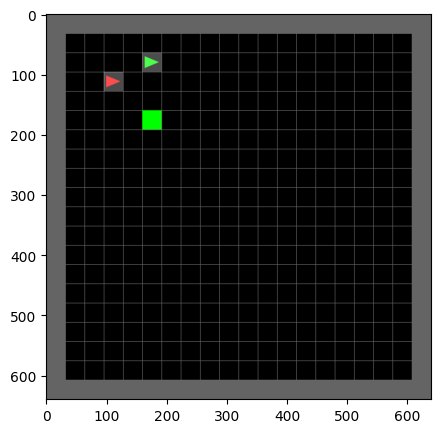

After Step 5: 
dict_keys([0, 1, 'global'])
Num of remaining target(s): 1
Agent 0's Location: (np.int64(3), np.int64(3))
Agent 1's Location: (np.int64(5), np.int64(2))
Are agents idling? False
Is Agent 0 idling? True
Is Agent 1 idling? False
Terminations: False {0: np.False_, 1: np.False_}
Truncations: {0: False, 1: False}


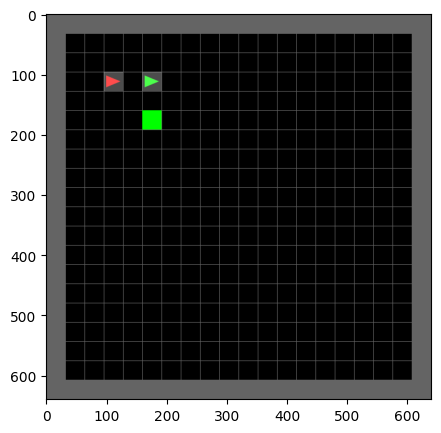

After Step 6: 
dict_keys([0, 1, 'global'])
Num of remaining target(s): 1
Agent 0's Location: (np.int64(3), np.int64(3))
Agent 1's Location: (np.int64(5), np.int64(3))
Are agents idling? False
Is Agent 0 idling? True
Is Agent 1 idling? False
Terminations: False {0: np.False_, 1: np.False_}
Truncations: {0: False, 1: False}


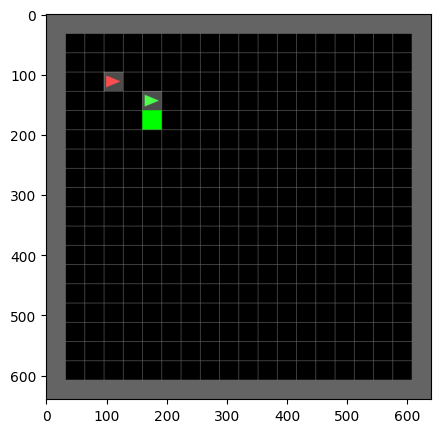

After Step 7: 
dict_keys([0, 1, 'global'])
Num of remaining target(s): 1
Agent 0's Location: (np.int64(3), np.int64(3))
Agent 1's Location: (np.int64(5), np.int64(4))
Are agents idling? False
Is Agent 0 idling? True
Is Agent 1 idling? False
Terminations: False {0: np.False_, 1: np.False_}
Truncations: {0: False, 1: False}


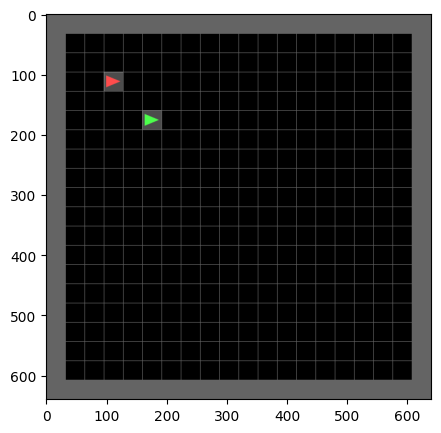

After Step 8: 
dict_keys([0, 1, 'global'])
Num of remaining target(s): 0
Agent 0's Location: (np.int64(3), np.int64(3))
Agent 1's Location: (np.int64(5), np.int64(5))
Are agents idling? True
Is Agent 0 idling? True
Is Agent 1 idling? True
Terminations: True {0: np.True_, 1: np.True_}
Truncations: {0: False, 1: False}
All agents are idle.


In [6]:
env = multigrid.envs.EmptyEnvV2(size=20, # Specify the size of the grid, N
                                agents=2, # Specify number of agents, M
                                goals=[(5, 5)], # Specify target positions for agents
                                mission_space= "One target is contained within the region from (1, 1) to (5, 5).",
                                render_mode='rgb_array', 
                                hidden_goals=True, 
                                )

# Always reset the environment before starting
observations, infos = env.reset()

###############################################################
# Initial observations
print("Initial Observations:")
print(observations.keys()) # Should contain 'global' and agent-specific keys like 0, 1, etc.
print("Mission:", observations[0]['mission']) # Mission statement for Agent 0. This will be the same for all agents.
print("Num of remaining target(s):", observations['global']['num_goals']) # The number of remaining targets in the environment

# Inital location of each agent. Always start at (1, 1).
print("Agent 0's Location:", observations[0]['location'])
print("Agent 1's Location:", observations[1]['location'])
###############################################################

# Create a group of 2 agents
agents = AgentCollection(num=2)

# Providing the agents with high-level instructions
agents.tell({
    0: "move(1, 1, 3, 3)",
    1: "move(1, 1, 5, 5)", 
})

while not env.unwrapped.is_done():
    # Step the environment with the actions
    observations, rewards, terminations, truncations, infos = env.step(agents.act())
    
    # Render the environment
    img = env.render()
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.show()
    
    ###############################################################
    # Current observations
    print(f"After Step {env.unwrapped.step_count}: ")
    print(observations.keys()) # Similarly, should contain 'global' and agent-specific keys like 0, 1, etc.
    print("Num of remaining target(s):", observations['global']['num_goals']) # The number of remaining targets in the environment

    # New locations of agents after each step.
    print("Agent 0's Location:", observations[0]['location'])
    print("Agent 1's Location:", observations[1]['location'])

    # To check if the agents are still active. Agents will be idle if they have completed all their high-level actions.
    print("Are agents idling?", agents.all_idle())
    print("Is Agent 0 idling?", agents.idle(0))
    print("Is Agent 1 idling?", agents.idle(1))
    
    # Terminations
    print("Terminations:", env.unwrapped.is_done(), terminations) # Will be True if all targets are found or if max_steps is reached.
    print("Truncations:", truncations) # Will be True if the environment is truncated, i.e., exceeding max_steps.
    ###############################################################
    
    if agents.all_idle():
        print("All agents are idle.")
        break 
env.close()

---
## Rewards

At each timestep $t$, each agent $m$, will recieve the following reward: 
$$
r^m_t = \begin{cases}
    1,  & \text{if Agent } m \text{ found a target}\\
    -1, & \text{otherwise}
\end{cases}
$$

The collective reward for all $M$ agents at timestep $t$ is the mean of their individual rewards.
$$
r_t = \frac{1}{M}\sum^{m}_{n=1} r_{t}^m
$$

For a trajectory $\tau$, which is a sequence of states and actions representing a single rollout of interactions with the environment, the cummulative reward at the final timestep $T$ is:
$$
R(\tau) = \sum^{T}_{t=0}\gamma^t r_t + B
$$
where $\gamma=0.99$ and
$$
B = \begin{cases}
    (2 - \frac{T}{T_{max}}) * \frac{1}{1 - \gamma}, & \text{if all targets are found} \\
    0, & \text{otherwise}
\end{cases}
$$

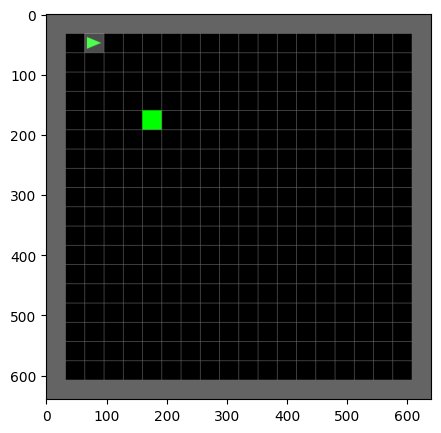

After Step 1: 
Individual agent reward: {0: -1, 1: -1}
Collective reward for current timestep: -1.0
Cumulative reward: -1.0


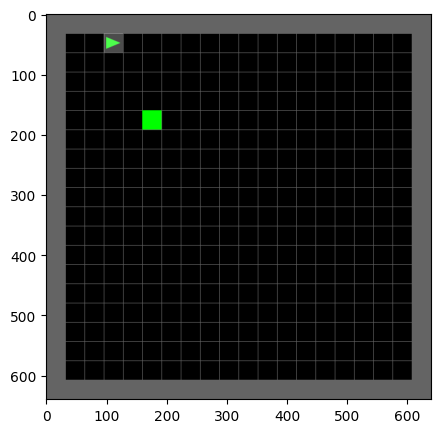

After Step 2: 
Individual agent reward: {0: -1, 1: -1}
Collective reward for current timestep: -1.0
Cumulative reward: -1.99


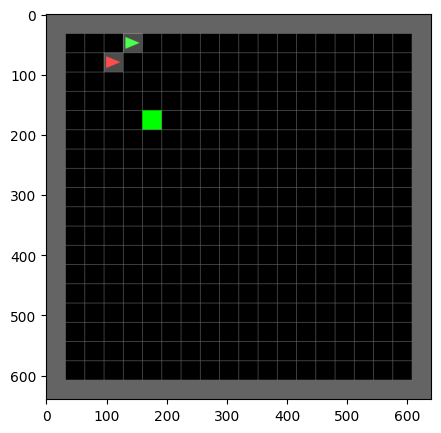

After Step 3: 
Individual agent reward: {0: -1, 1: -1}
Collective reward for current timestep: -1.0
Cumulative reward: -2.9701


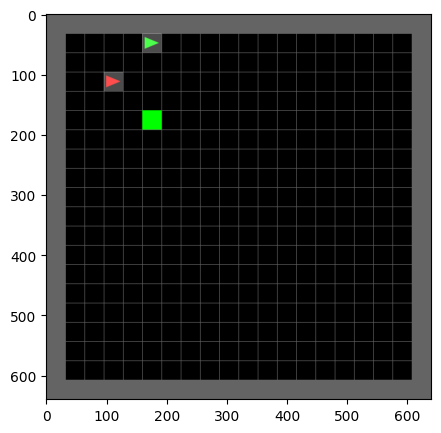

After Step 4: 
Individual agent reward: {0: -1, 1: -1}
Collective reward for current timestep: -1.0
Cumulative reward: -3.940399


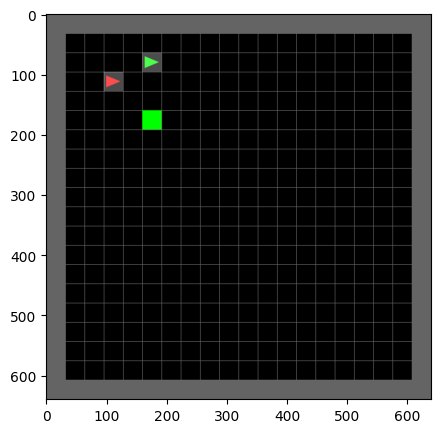

After Step 5: 
Individual agent reward: {0: -1, 1: -1}
Collective reward for current timestep: -1.0
Cumulative reward: -4.90099501


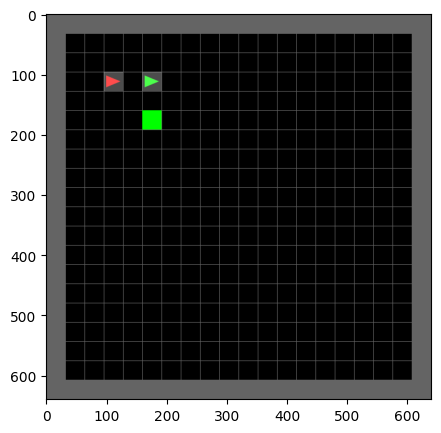

After Step 6: 
Individual agent reward: {0: -1, 1: -1}
Collective reward for current timestep: -1.0
Cumulative reward: -5.8519850599


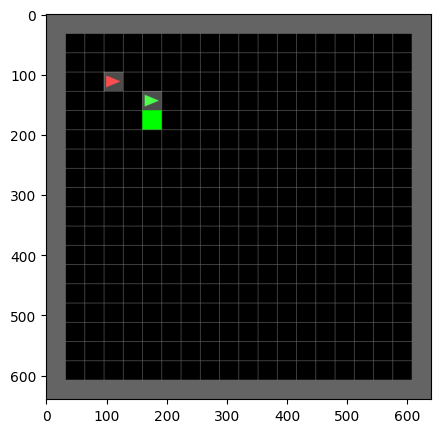

After Step 7: 
Individual agent reward: {0: -1, 1: -1}
Collective reward for current timestep: -1.0
Cumulative reward: -6.793465209301


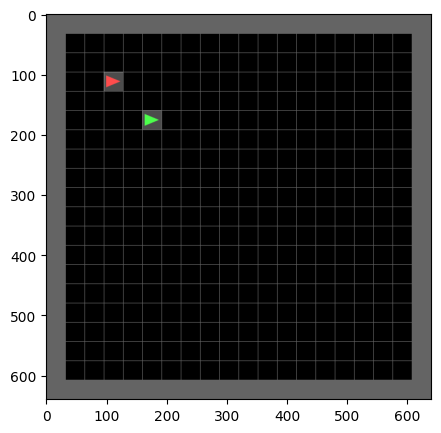

After Step 8: 
Individual agent reward: {0: -1, 1: 1}
Collective reward for current timestep: 199.56249999999983
Cumulative reward: 179.21182578238754
All agents are idle.


In [ ]:
env = multigrid.envs.EmptyEnvV2(size=20, # Specify the size of the grid, N
                                agents=2, # Specify number of agents, M
                                goals=[(5, 5)], # Specify target positions for agents
                                mission_space= "One target is contained within the region from (1, 1) to (5, 5).",
                                render_mode='rgb_array', 
                                hidden_goals=True, 
                                )

# Always reset the environment before starting
observations, infos = env.reset()

# Create a group of 2 agents
agents = AgentCollection(num=2)

# Providing the agents with high-level instructions.
# Again, these instructions should be generated by your LLM and not hardcoded.
agents.tell({
    0: "move(1, 1, 3, 3)",
    1: "move(1, 1, 5, 5)", 
})

while not env.unwrapped.is_done():
    # Step the environment with the actions
    observations, rewards, terminations, truncations, infos = env.step(agents.act())
    
    # Render the environment
    img = env.render()
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.show()
    
    ###############################################################
    # Current rewards
    print(f"After Step {env.unwrapped.step_count}: ")
    print("Individual agent reward:", rewards) # Rewards for each agent at the current step
    print("Collective reward for current timestep:", infos['cur_reward'])
    print("Cumulative reward:", infos['total_reward'])
    ###############################################################
    
    if agents.all_idle():
        print("All agents are idle.")
        break 
env.close()

---
## Advance Usage
We can chain high-level actions (Example 1) and also dynamically replans (Example 2 and Example 3).

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


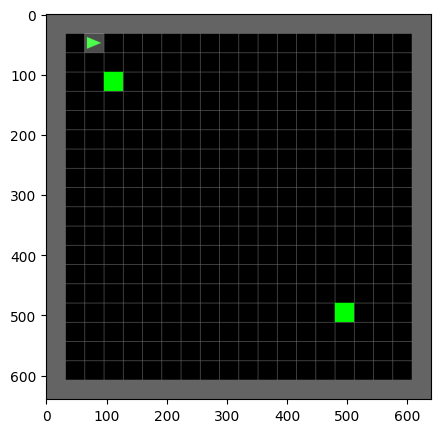

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


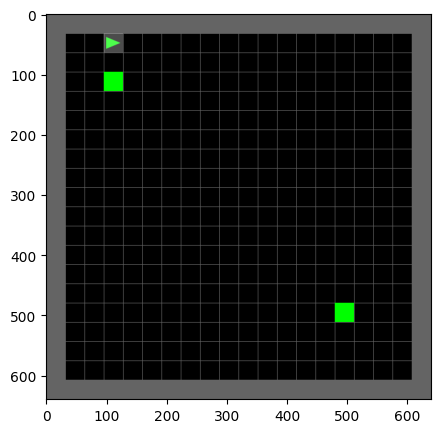

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


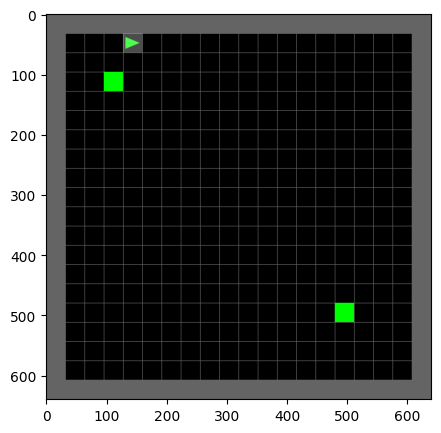

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


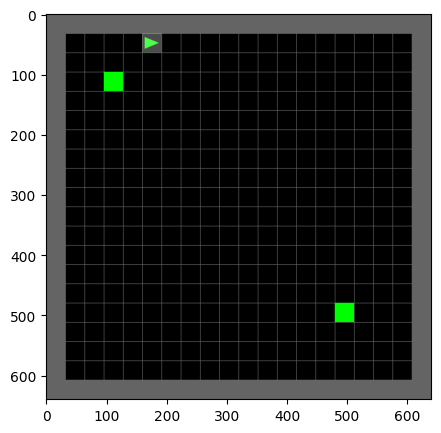

{0: <ActionUpDown.down: 3>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


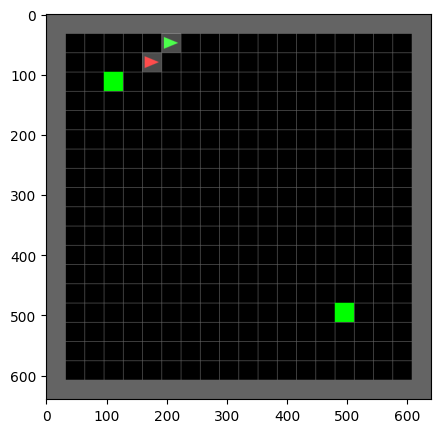

{0: <ActionUpDown.left: 0>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


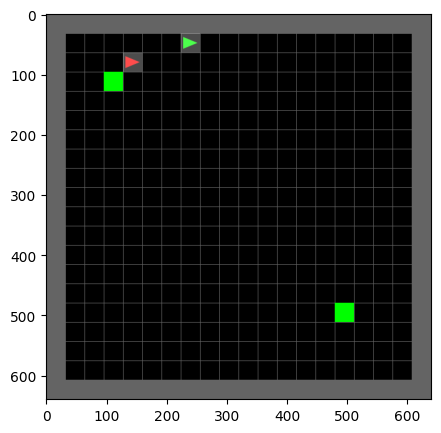

{0: <ActionUpDown.left: 0>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


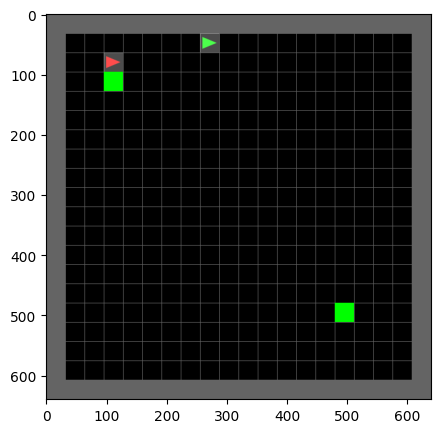

{0: <ActionUpDown.left: 0>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


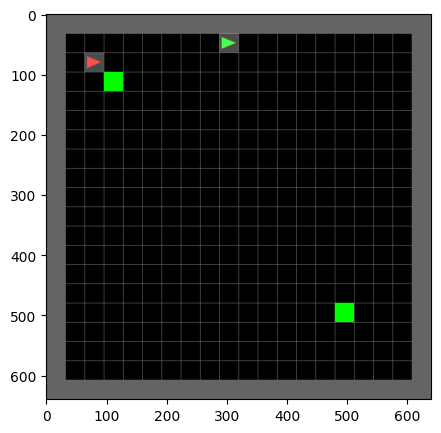

{0: <ActionUpDown.left: 0>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


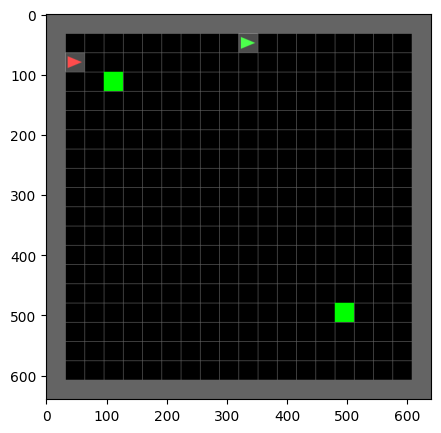

{0: <ActionUpDown.down: 3>, 1: <ActionUpDown.down: 3>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


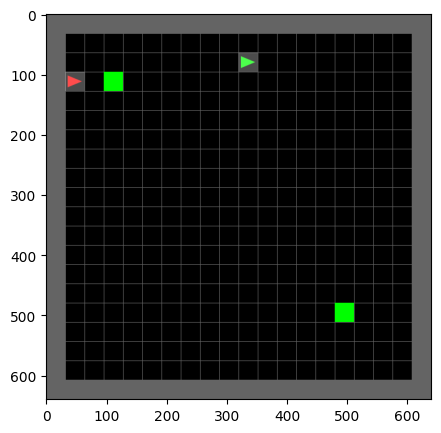

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.down: 3>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


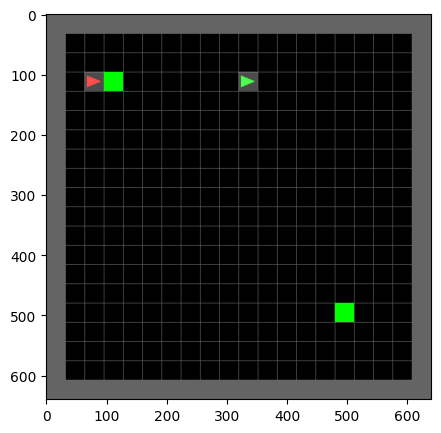

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.down: 3>} {0: 1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


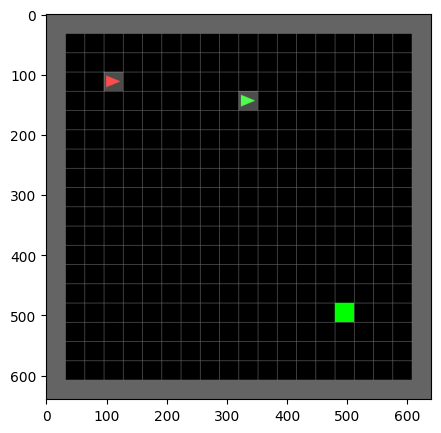

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.down: 3>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


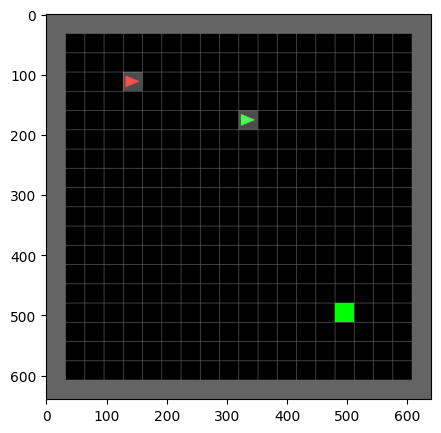

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.down: 3>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


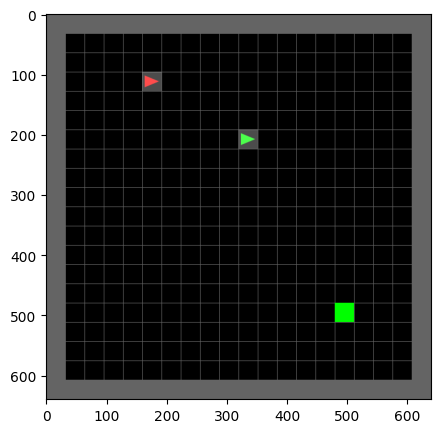

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.down: 3>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


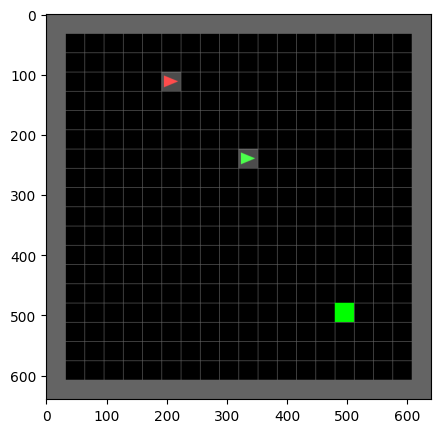

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.down: 3>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


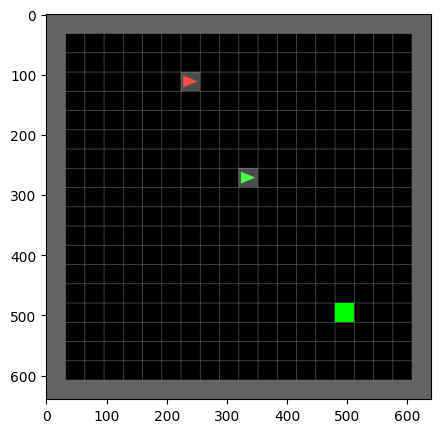

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.down: 3>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


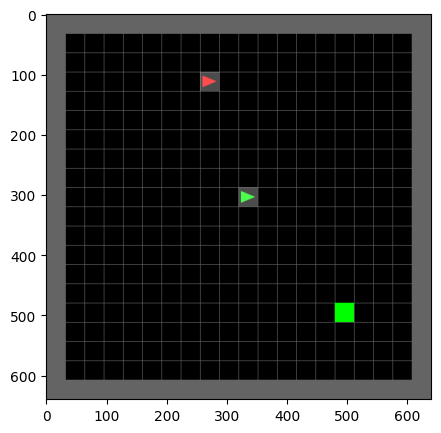

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.down: 3>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


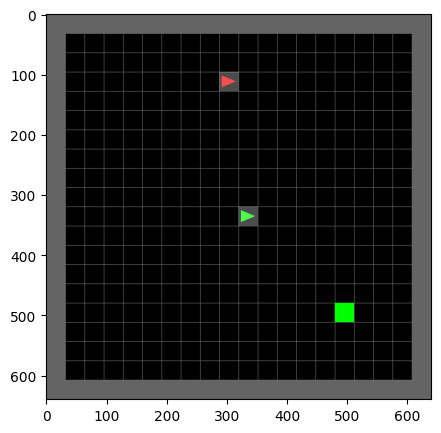

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


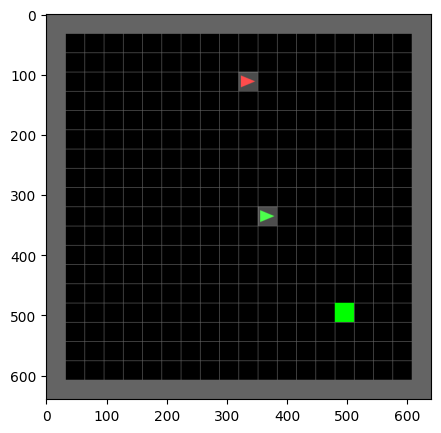

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


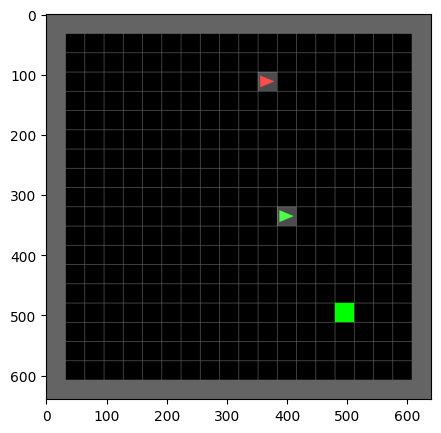

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


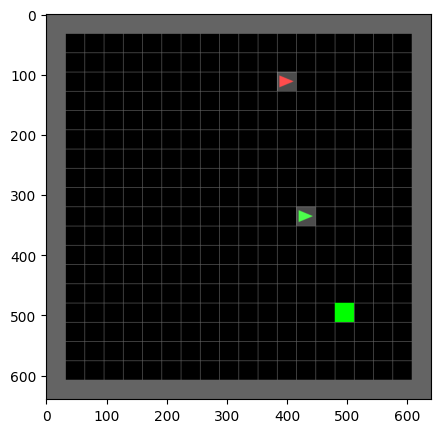

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.down: 3>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


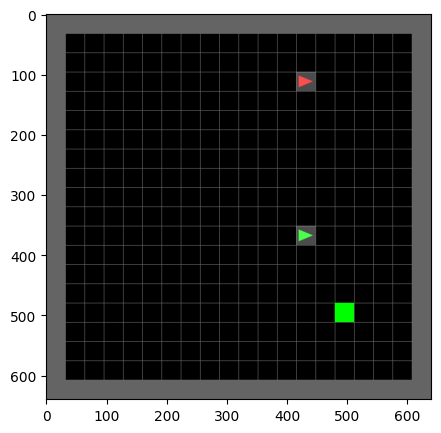

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.left: 0>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


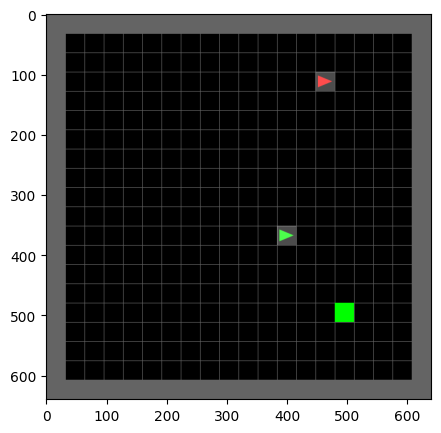

{0: <ActionUpDown.down: 3>, 1: <ActionUpDown.left: 0>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


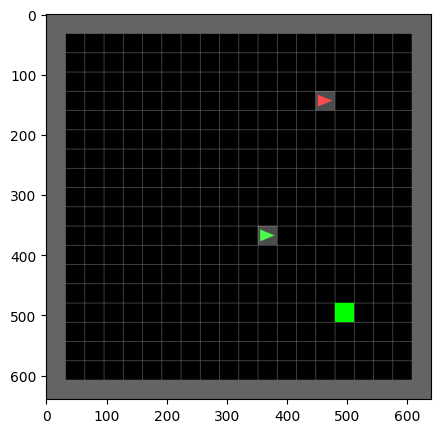

{0: <ActionUpDown.down: 3>, 1: <ActionUpDown.left: 0>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


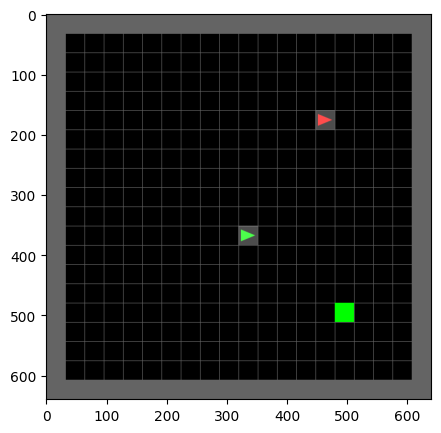

{0: <ActionUpDown.down: 3>, 1: <ActionUpDown.down: 3>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


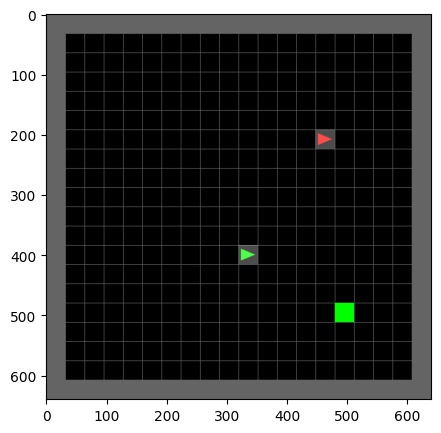

{0: <ActionUpDown.down: 3>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


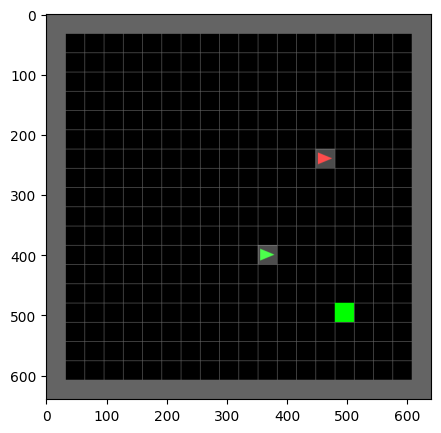

{0: <ActionUpDown.down: 3>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


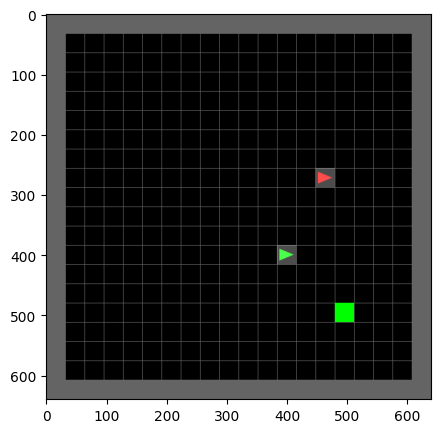

{0: <ActionUpDown.down: 3>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


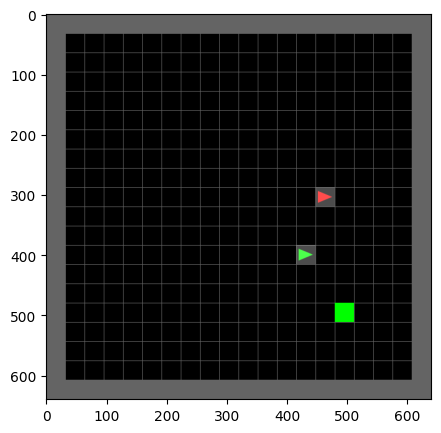

{0: <ActionUpDown.down: 3>, 1: <ActionUpDown.down: 3>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


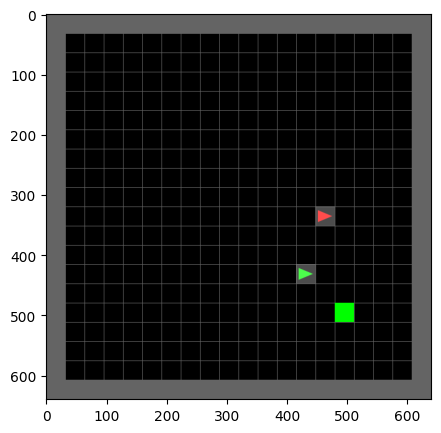

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.left: 0>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


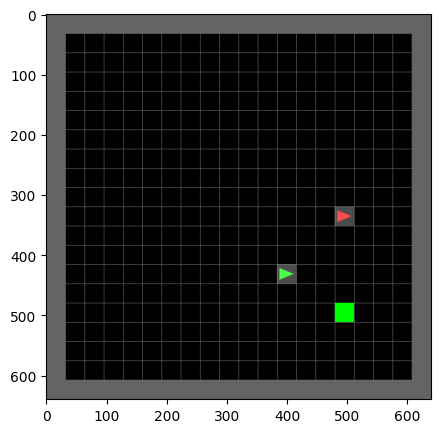

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.left: 0>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


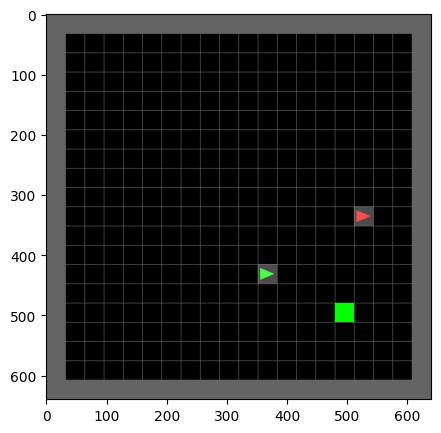

{0: <ActionUpDown.down: 3>, 1: <ActionUpDown.left: 0>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


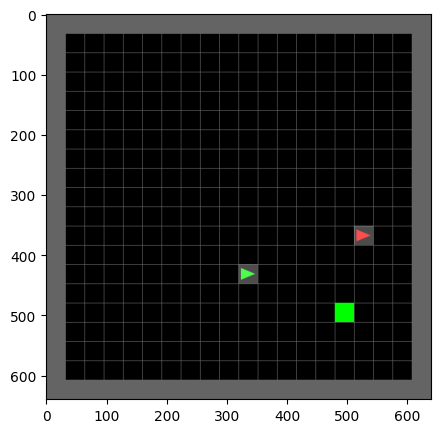

{0: <ActionUpDown.left: 0>, 1: <ActionUpDown.down: 3>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


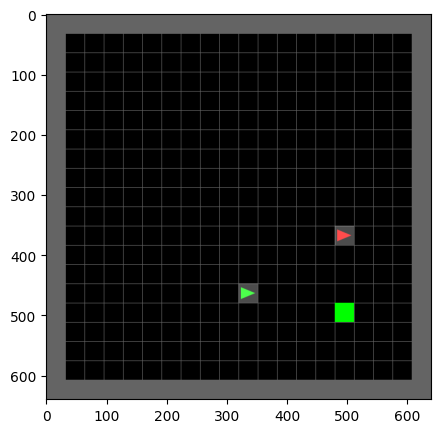

{0: <ActionUpDown.left: 0>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


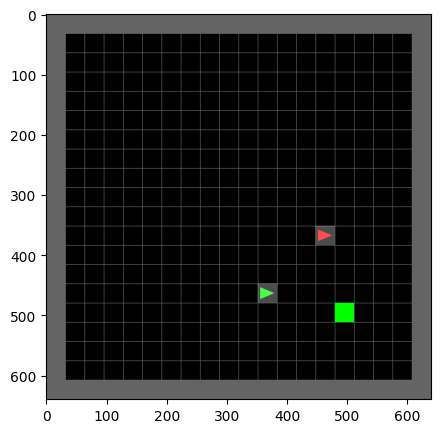

{0: <ActionUpDown.down: 3>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


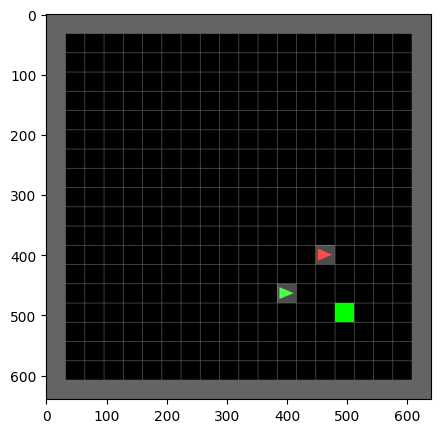

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


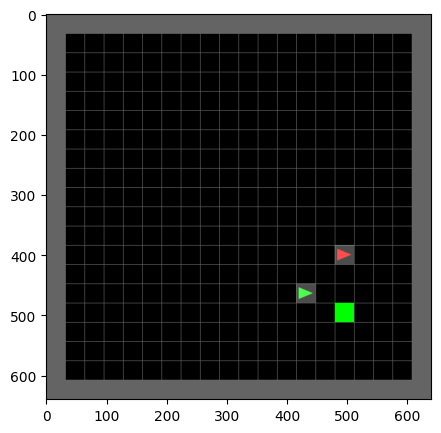

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.down: 3>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


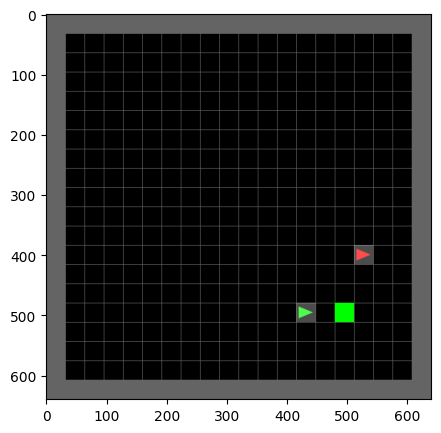

{0: <ActionUpDown.down: 3>, 1: <ActionUpDown.left: 0>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


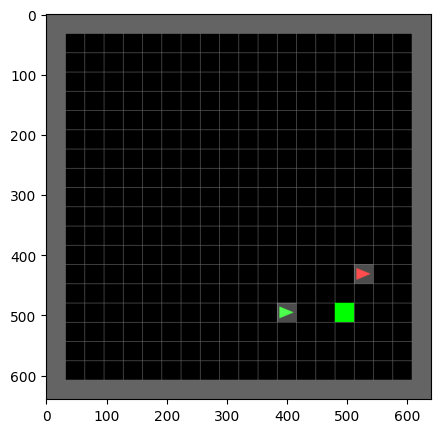

{0: <ActionUpDown.left: 0>, 1: <ActionUpDown.left: 0>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


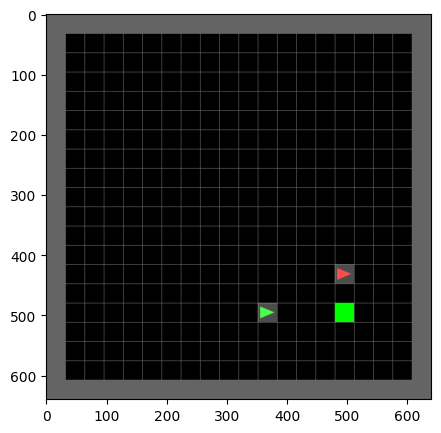

{0: <ActionUpDown.left: 0>, 1: <ActionUpDown.left: 0>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


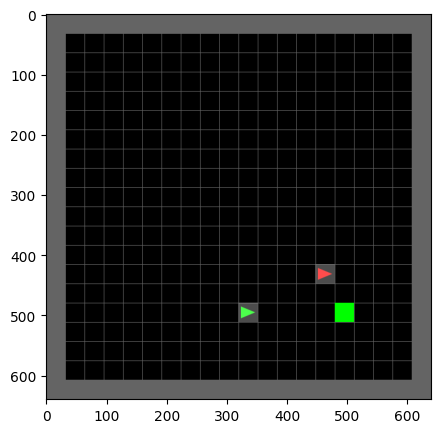

{0: <ActionUpDown.down: 3>, 1: <ActionUpDown.done: 7>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


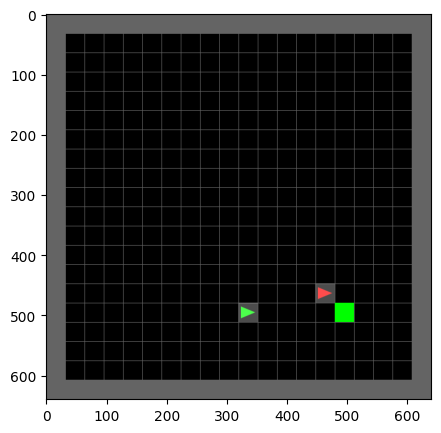

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.done: 7>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


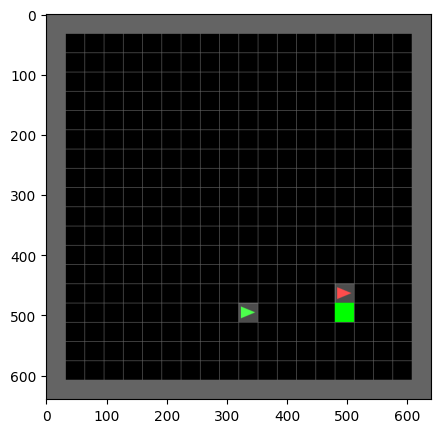

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.done: 7>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


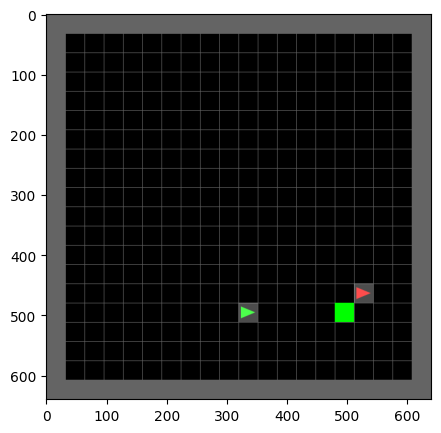

{0: <ActionUpDown.down: 3>, 1: <ActionUpDown.done: 7>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


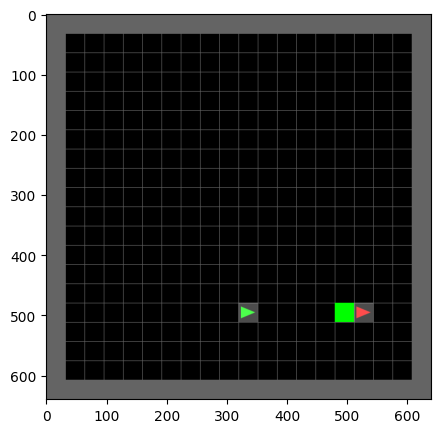

{0: <ActionUpDown.left: 0>, 1: <ActionUpDown.done: 7>} {0: 1, 1: -1} {0: np.True_, 1: np.True_} {0: False, 1: False}


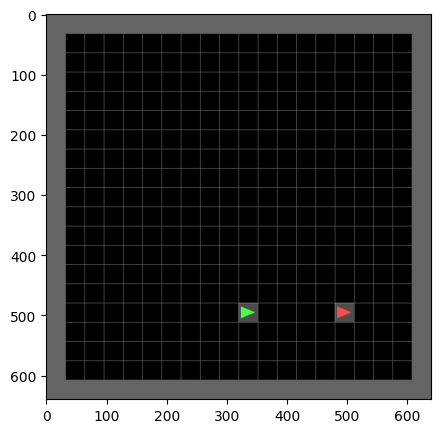

In [ ]:
env = multigrid.envs.EmptyEnvV2(size=20, # Specify the size of the grid, N
                                agents=2, # Specify number of agents, M
                                goals=[(3, 3), (15, 15)], # Specify target positions for agents
                                mission_space= "One target is contained within the region from (1, 1) to (5, 5) and the other target is contained within the region from (10, 10) to (16, 16).",
                                render_mode='rgb_array', 
                                hidden_goals=True, 
                                )

# Always reset the environment before starting
observations, infos = env.reset()

# Create a group of 2 agents
agents = AgentCollection(num=2)

# Providing the agents with high-level instructions.
# Again, these instructions should be generated by your LLM and not hardcoded.
agents.tell({
    0: "search(1, 1, 1, 1, 5, 5)",
    1: "move(1, 1, 10, 10)",
})

# Example 1: Chaining high-level actions for Agent 1
agents.tell({
    1: "search(10, 10, 10, 10, 13, 15)",
})
while not env.unwrapped.is_done():
    # Obtain the low-level action for current time step for all agents
    a = agents.act()
    
    # Step the environment with the actions
    observations, rewards, terminations, truncations, infos = env.step(a)
    print(a, rewards, terminations, truncations)
    
    # Render the environment
    img = env.render()
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.show()
    
    # Example 2: Replan after finding a target.
    for i in agents.agents:
        if rewards[i] > 0: # Agent i has found a target
            # Stop Agent i if it has found a target
            agents.tell({i: "stop()"})
            # Replan Agent i to search for the second target
            cur_x, cur_y = observations[i]['location']
            agents.tell({i: f"search({cur_x}, {cur_y}, 14, 10, 16, 16)"})
            
    # Example 3: Replan when all agents are idle
    if agents.all_idle():
        print("All agents are idle.")
        # Consider to do something here, e.g., replan with LLM
        break    
env.close()

---
# Resources

[Introduction to RL - OpenAI](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html)